In [1]:
%env WANDB_PROJECT=nlu_sentiment_analysis
!wandb login 2cad8a8279143c69ce071f54bf37c1f5a5f4e5ff
import wandb

from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import requests, re, string, datetime, copy
from functools import partial

import torch
import torchvision.transforms as T, torch.nn.functional as F, torch.nn as nn

from datasets import Dataset
from transformers import TrainingArguments, EarlyStoppingCallback, TrainerCallback
from transformers import Trainer
from transformers.modeling_outputs import SequenceClassifierOutput

from sklearn.model_selection import train_test_split

PATH = "./data/Sentipolc16/"

env: WANDB_PROJECT=nlu_sentiment_analysis
wandb: Appending key for api.wandb.ai to your netrc file: /home/steve/.netrc


In [2]:
import datasets
datasets.__version__

'1.9.0'

In [3]:
train = pd.read_csv(PATH + "training_set_sentipolc16.csv")
train.head()

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text
0,122449983151669248,1,0,1,0,0,1,1,Intanto la partita per Via Nazionale si compli...
1,125485104863780865,1,0,1,0,0,1,1,"False illusioni, sgradevoli realtà Mario Monti..."
2,125513454315507712,1,0,1,0,0,1,1,"False illusioni, sgradevoli realtà #editoriale..."
3,125524238290522113,1,0,1,0,0,1,1,Mario Monti: Berlusconi risparmi all'Italia il...
4,125527933224886272,1,0,1,0,0,1,1,Mario Monti: Berlusconi risparmi all'Italia il...


In [4]:
file1 = open(PATH + "test_set_sentipolc16_gold2000.csv", 'r') 
Lines = file1.readlines()
 
test = []
for line in Lines:
  arr = line.split("\",")
  if len(arr) != 9:
    arr[8] = arr[8] + arr[9]  #to account for tweets containing the delimiter charachter that would create more splits than needed
    del arr[9:]
  for i in range(8):
    arr[i] = int(arr[i].strip("\""))
  test.append(arr)

test = pd.DataFrame(test, columns=train.columns)
test.head()

,idtwitter,subj,opos,oneg,iro,lpos,lneg,top,text
0,507074506880712705,0,0,0,0,0,0,2,"""Tra 5 minuti presentazione piano scuola del g..."
1,507075789456961536,1,1,0,0,1,0,2,"""\""@matteorenzi: Alle 10 appuntamento su http:..."
2,507077511902425088,1,0,1,0,0,1,2,"""#labuonascuola gli #evangelisti #digitali non..."
3,507079183315787777,0,0,0,0,0,0,2,"""Riforma scuola Tutto il discorso di Renzi su..."
4,507080190225563648,1,0,0,0,0,0,2,""".@matteorenzi @MiurSocial #labuonascuola bast..."


In [5]:
"""Tokenization classes for Italian AlBERTo models."""
import collections
import os

#from transformers import BertTokenizer, WordpieceTokenizer

def separate2united_labels(row):
  """
  Return a single scalar integer label associated to the polarity of the tweet.

  Negative -> 0
  Neutral  -> 1
  Positive -> 2
  Mixed    -> 3
  """
  if row["opos"] == 0 and row["oneg"] == 0:
    return 1
  elif row["oneg"] == 0 and row["opos"] == 1:
    return 2
  elif row["oneg"] == 1 and row["opos"] == 0:
    return 0
  else:
    return 3

def load_vocab(vocab_file):
    """Loads a vocabulary file into a dictionary."""
    vocab = collections.OrderedDict()
    with open(vocab_file, "r", encoding="utf-8") as reader:
        tokens = reader.readlines()
    for index, token in enumerate(tokens):
        token = token.rstrip("\n")
        vocab[token] = index
    return vocab

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'user', 'percent', 'money', 'phone', 'time', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag"},
    fix_html=True,  # fix HTML tokens

    unpack_hashtags=True,  # perform word segmentation on hashtags

    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    dicts=[emoticons]
)

class AlBERTo_Preprocessing(object):
    def __init__(self, do_lower_case=True, **kwargs):
        self.do_lower_case = do_lower_case

    def preprocess(self, text):
        if self.do_lower_case:
            text = text.lower()
        text = str(" ".join(text_processor.pre_process_doc(text)))
        text = re.sub(r'[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
        text = re.sub(r'^\s', '', text)
        text = re.sub(r'\s$', '', text)
        return text

a = AlBERTo_Preprocessing(do_lower_case=True)
s = "#IlGOverno presenta le linee guida sulla scuola #labuonascuola - http://t.co/SYS1T9QmQN"
b = a.preprocess(s)
print(b)

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading english - 1grams ...
Reading english - 2grams ...


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...
<hashtag> il governo </hashtag> presenta le linee guida sulla scuola <hashtag> la buona scuola </hashtag> <url>


In [6]:
def k_steps_evidence(num_iterations, early_stopping_patience, training_args, net, training_opos, training_oneg, testing_opos, testing_oneg, validating_opos, validating_oneg):
    np.random.seed(0)
    torch.manual_seed(0)

    keys = ["eval_loss", "eval_accuracy", "eval_f1", "eval_precision", "eval_recall"]
    metrics = { i + sa: [] for i in keys for sa in ["_opos", "_oneg"]}
    for i in range(num_iterations):
        for subtask , training , testing , validating in zip(["opos", "oneg"], [training_opos, training_oneg], [testing_opos, testing_oneg], [validating_opos, validating_oneg]):
            trainer = Trainer(
                model=net(2),
                args=training_args, 
                train_dataset=training.shuffle(seed=i), 
                eval_dataset=validating, 
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=early_stopping_patience)]
            )
            trainer.train()
            res = trainer.evaluate(testing)
            for m in keys:
                metrics[m + "_" + subtask].append(res[m])

    for m in metrics.keys():
        print("{:18s}\t: {:.4} ± {:.4}".format(m, np.mean(metrics[m]), np.std(metrics[m])))
    print("\nOverall F1: {:.4}".format(np.mean(
        [np.mean(metrics["eval_f1_opos"]), np.mean(metrics["eval_f1_oneg"])]
    )))

In [7]:
from transformers import AutoTokenizer, AutoModel

a = AlBERTo_Preprocessing(do_lower_case=True)
s: str = "#IlGOverno presenta le linee guida sulla scuola #labuonascuola - http://t.co/SYS1T9QmQN"
b = a.preprocess(s)

tok = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
pretrained_model = AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
tok.model_max_length = 128 #model.config.max_position_embeddings
tokens = tok.tokenize(b)
print(tokens)

['<', 'ha', '##shtag', '>', 'il', 'governo', '<', '/', 'ha', '##shtag', '>', 'presenta', 'le', 'linee', 'guida', 'sulla', 'scuola', '<', 'ha', '##shtag', '>', 'la', 'buona', 'scuola', '<', '/', 'ha', '##shtag', '>', '<', 'ur', '##l', '>']


In [8]:
s = "#IlGOverno presenta le linee guida sulla scuola #labuonascuola - http://t.co/SYS1T9QmQN"
o = pretrained_model(**tok("ciao " * 1000, return_tensors="pt", truncation=True))

o[0].shape , o[1].shape

(torch.Size([1, 128, 768]), torch.Size([1, 768]))

In [9]:
class MyNet(nn.Module):
    """
        Attach a FC layer on top of the BERT head in order to produce a classification output.
        Hyperparameters are taken from Alberto.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer with Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels):
        super(MyNet, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)#AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768, num_labels)

        if self.num_labels >= 2:
            self.loss_fct = nn.CrossEntropyLoss()
        else:
            self.loss_fct = nn.BCEWithLogitsLoss()


    def forward(self, labels, input_ids, attention_mask, **args):
        #For the output format -> https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForSequenceClassification.forward
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        x = self.dropout(outputs[1])
        logits = self.linear(x)

        loss = self.loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [10]:
def tokenize_function(examples):
    sa = tok(examples["text"], padding="max_length", truncation=True)
    return sa

def separate2united_labels2(row):
    return str(row["opos"]) + str(row["oneg"])

def process_dataset_task(example, subtask):
    example["labels"] = int(example["labels"][0]) if subtask == "opos" else int(example["labels"][1])
    return example

#train set
dataset = pd.DataFrame({"text": train.text.apply(a.preprocess), "idx": train.index, "labels": train[["opos", "oneg"]].apply(separate2united_labels2, axis=1)})
X_train, X_val = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset["labels"])

X_train = Dataset.from_pandas(X_train)
X_val = Dataset.from_pandas(X_val)


##
# Create a Dataset for each subtask (evaluated separately by SentiPolc16).
# To do that, simply take, respectively, the first or the second char of the label for opos and oneg.
##
training_opos = X_train\
                    .map(process_dataset_task, fn_kwargs={"subtask": "opos"}, batched=False)\
                    .map(tokenize_function, batched=True)\
                    .shuffle(seed=42)\
                    .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
training_oneg = X_train\
                   .map(process_dataset_task, fn_kwargs={"subtask": "oneg"}, batched=False)\
                   .map(tokenize_function, batched=True)\
                   .shuffle(seed=42)\
                   .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
validating_opos = X_val\
                    .map(process_dataset_task, fn_kwargs={"subtask": "opos"}, batched=False)\
                    .map(tokenize_function, batched=True)\
                    .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
validating_oneg = X_val\
                   .map(process_dataset_task, fn_kwargs={"subtask": "oneg"}, batched=False)\
                   .map(tokenize_function, batched=True)\
                   .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])


#test set
dataset = pd.DataFrame({"text": test.text.apply(a.preprocess), "idx": test.index, "labels": test[["opos", "oneg"]].apply(separate2united_labels2, axis=1)})
dataset = Dataset.from_pandas(dataset)

##
# Create a Dataset for each subtask (evaluated separately by SentiPolc16).
# To do that, simply take, respectively, the first or the second char of the label for opos and oneg.
##
testing_opos = dataset.map(process_dataset_task, fn_kwargs={"subtask": "opos"}, batched=False).map(tokenize_function, batched=True).shuffle().with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
testing_oneg = dataset\
                    .map(process_dataset_task, fn_kwargs={"subtask": "oneg"}, batched=False)\
                    .map(tokenize_function, batched=True)\
                    .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])

In [11]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='macro')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

class MemorySaverCallback(TrainerCallback):
    "A callback that deleted the folder in which checkpoints are saved, to save memory"
    def __init__(self, run_name):
        super(MemorySaverCallback, self).__init__()
        self.run_name = run_name

    def on_train_begin(self, args, state, control, **kwargs):
        print("Removing dirs...")
        if os.path.isdir(f'./{self.run_name}'):
            import shutil
            shutil.rmtree(f'./{self.run_name}')
        else:
            print("\n\nDirectory does not exists")

TRAIN_BATCH_SIZE = 64 
PREDICT_BATCH_SIZE = 64
EVAL_BATCH_SIZE = 64 
LEARNING_RATE = 2e-5
NUM_TRAIN_EPOCHS = 3
MAX_SEQ_LENGTH = 128
WARMUP_PROPORTION = 0.1
num_train_steps = int(len(training_opos) / TRAIN_BATCH_SIZE * NUM_TRAIN_EPOCHS)+1
NUM_WARMUP_STEPS =  int(NUM_TRAIN_EPOCHS * WARMUP_PROPORTION)
RUN_NAME = "test_trainer"

## Baseline with train-val splitting

In [12]:
args = TrainingArguments(
                "test_trainer", 
                num_train_epochs=15,
                per_device_train_batch_size=TRAIN_BATCH_SIZE,
                per_device_eval_batch_size=PREDICT_BATCH_SIZE,
                save_total_limit=2,
                learning_rate=LEARNING_RATE,
                warmup_ratio=WARMUP_PROPORTION,
                weight_decay=0.01,
                adam_beta1=0.9,
                adam_beta2=0.999,
                adam_epsilon=1e-6,
                evaluation_strategy="epoch",
                logging_strategy="epoch", #before was 'step', check this
                logging_first_step=False,
                overwrite_output_dir=True,
                save_strategy="no",
                report_to="none",
                run_name="alberto-repr-beast-warmup_ratio_0.1",
                load_best_model_at_end=True,  
                metric_for_best_model="eval_f1",
            )

k_steps_evidence(num_iterations=5, 
                 early_stopping_patience=3,
                 training_args=args, 
                 net=MyNet, 
                 training_opos=training_opos, 
                 training_oneg=training_oneg, 
                 validating_opos=validating_opos,
                 validating_oneg=validating_oneg,
                 testing_opos=testing_opos, 
                 testing_oneg=testing_oneg)          

#wandb.finish()
#WARMUP_STEPS computde with 3 but run with eraly stopping. Before 0.70
#3 epochs is really better? -> 0.7398 with usual warmnup
#setting warmup_ratio = 0.1 instead of warmup_steps -> 0.745

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.551000,0.445484,0.798920,0.693925,0.788663,0.671228,3.776900,392.390000
2,0.422700,0.373454,0.829960,0.773075,0.797648,0.757449,3.848400,385.096000
3,0.295300,0.401144,0.825236,0.771046,0.787258,0.759456,3.877800,382.173000
4,0.177500,0.475842,0.811066,0.770353,0.764034,0.778279,3.898100,380.186000
5,0.098800,0.557083,0.825236,0.774493,0.784918,0.766234,3.904200,379.593000
6,0.051000,0.790200,0.825236,0.769450,0.788504,0.756443,3.909700,379.055000
7,0.037000,0.870299,0.827935,0.782220,0.786158,0.778643,3.912300,378.807000
8,0.023600,1.005511,0.821188,0.777117,0.776500,0.777744,3.913400,378.699000
9,0.020200,1.142568,0.800945,0.764500,0.754413,0.781073,3.916700,378.381000
10,0.011300,1.185285,0.823887,0.779487,0.780128,0.778856,3.916700,378.381000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.609100,0.496865,0.751687,0.739702,0.742227,0.737853,3.942100,375.938000
2,0.455200,0.442873,0.794197,0.790262,0.788288,0.797703,3.908900,379.132000
3,0.319500,0.457171,0.794197,0.786968,0.785948,0.788164,3.914500,378.588000
4,0.195800,0.560074,0.793522,0.783292,0.786727,0.780785,3.916100,378.441000
5,0.107700,0.730971,0.784750,0.775489,0.776579,0.774531,3.915800,378.469000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.572700,0.442176,0.788124,0.671920,0.772988,0.652469,3.917500,378.303000
2,0.432600,0.393021,0.827260,0.769888,0.793355,0.754830,3.917300,378.321000
3,0.306800,0.384842,0.831984,0.788660,0.790707,0.786713,3.921500,377.917000
4,0.188000,0.488849,0.814440,0.779350,0.769217,0.794919,3.917700,378.281000
5,0.105700,0.538301,0.817139,0.772410,0.771411,0.773439,3.917000,378.346000
6,0.058700,0.722760,0.829960,0.786277,0.788074,0.784560,3.918800,378.174000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.613300,0.501646,0.754386,0.740740,0.745888,0.737660,3.911000,378.927000
2,0.439500,0.451223,0.794872,0.789347,0.787102,0.793362,3.916500,378.396000
3,0.315800,0.476106,0.796221,0.788224,0.788224,0.788224,3.917500,378.300000
4,0.190300,0.574206,0.779352,0.770249,0.770797,0.769739,3.919000,378.157000
5,0.104300,0.783917,0.786100,0.771132,0.783832,0.765304,3.932000,376.904000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.569900,0.434460,0.795547,0.686135,0.785398,0.664377,3.919100,378.152000
2,0.420200,0.389521,0.823212,0.745754,0.810572,0.720402,3.916800,378.371000
3,0.292000,0.432498,0.805668,0.770520,0.759972,0.788103,3.935500,376.573000
4,0.184600,0.443528,0.818489,0.781610,0.773141,0.793199,3.907800,379.244000
5,0.093700,0.608792,0.820513,0.768590,0.778502,0.760709,3.913700,378.670000
6,0.054500,0.709711,0.835358,0.781457,0.804140,0.766452,3.916700,378.380000
7,0.046100,0.810318,0.823212,0.768194,0.784601,0.756550,3.915600,378.484000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.615900,0.516746,0.731444,0.728812,0.731183,0.740255,3.913200,378.718000
2,0.446700,0.452672,0.793522,0.788335,0.786017,0.793050,3.915700,378.479000
3,0.312300,0.480952,0.789474,0.784091,0.781830,0.788570,3.914900,378.549000
4,0.188200,0.589695,0.798246,0.792765,0.790504,0.796732,3.917000,378.355000
5,0.106900,0.690582,0.787449,0.782343,0.780080,0.787420,3.900000,380.004000
6,0.066500,0.936822,0.788799,0.777710,0.782254,0.774650,3.914900,378.551000
7,0.040300,1.056392,0.789474,0.780099,0.781695,0.778758,3.916600,378.385000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.598100,0.487406,0.773954,0.627633,0.768722,0.617069,3.916000,378.448000
2,0.430100,0.394050,0.817814,0.744981,0.791805,0.723448,3.917200,378.333000
3,0.307900,0.403483,0.818489,0.779830,0.772874,0.788681,3.916300,378.417000
4,0.188100,0.471782,0.825236,0.785632,0.780908,0.791086,3.917200,378.329000
5,0.110500,0.574334,0.829285,0.773597,0.795290,0.759242,3.916800,378.374000
6,0.057400,0.820192,0.823212,0.783303,0.778457,0.788933,3.918300,378.225000
7,0.032100,0.985296,0.823887,0.780808,0.779778,0.781869,3.916900,378.357000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.631000,0.506071,0.750337,0.743263,0.741539,0.746262,3.914600,378.581000
2,0.446400,0.455823,0.782051,0.766453,0.779822,0.760551,3.916400,378.407000
3,0.327000,0.467889,0.785425,0.774231,0.778588,0.771280,3.915500,378.497000
4,0.198100,0.616103,0.788799,0.783816,0.781542,0.789095,3.914400,378.598000
5,0.102900,0.689119,0.790823,0.781635,0.783039,0.780433,3.914100,378.630000
6,0.064200,1.088021,0.784750,0.780717,0.778926,0.788158,3.914600,378.585000
7,0.048000,1.061498,0.788799,0.781492,0.780382,0.782827,3.913800,378.658000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.606300,0.447592,0.788799,0.714772,0.739374,0.701133,3.912900,378.743000
2,0.420100,0.397891,0.827260,0.776921,0.787743,0.768386,3.916300,378.419000
3,0.295100,0.434071,0.834008,0.772629,0.810762,0.751964,3.925200,377.558000
4,0.176300,0.477710,0.813765,0.768727,0.767174,0.770354,3.935800,376.543000
5,0.095800,0.610852,0.828610,0.780112,0.788624,0.773084,3.916200,378.432000
6,0.055400,0.756652,0.819838,0.781166,0.774442,0.789614,3.913600,378.676000
7,0.040100,0.896109,0.825911,0.758735,0.801756,0.737329,3.914300,378.613000
8,0.028200,0.893816,0.838057,0.790864,0.802204,0.781873,3.920300,378.035000
9,0.016100,1.030055,0.828610,0.780469,0.788410,0.773837,3.916100,378.440000
10,0.010200,1.192061,0.812416,0.773238,0.765838,0.782977,3.917100,378.345000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.609700,0.516301,0.747638,0.743860,0.743492,0.752452,3.915800,378.468000
2,0.453900,0.461779,0.773279,0.771057,0.773019,0.783732,3.887800,381.192000
3,0.312800,0.480550,0.790823,0.787620,0.786594,0.797059,3.911100,378.923000
4,0.186300,0.584888,0.786775,0.778406,0.778406,0.778406,3.914900,378.553000
5,0.105700,0.782729,0.775304,0.755169,0.778508,0.747815,3.915100,378.530000
6,0.070100,0.890203,0.789474,0.776272,0.785401,0.771399,3.916300,378.417000


eval_loss_opos    	: 0.7201 ± 0.2497
eval_loss_oneg    	: 0.5693 ± 0.1048
eval_accuracy_opos	: 0.7863 ± 0.02197
eval_accuracy_oneg	: 0.7764 ± 0.004964
eval_f1_opos      	: 0.6954 ± 0.01538
eval_f1_oneg      	: 0.745 ± 0.007006
eval_precision_opos	: 0.6791 ± 0.01285
eval_precision_oneg	: 0.7859 ± 0.006642
eval_recall_opos  	: 0.7448 ± 0.00774
eval_recall_oneg  	: 0.7346 ± 0.007059

Overall F1: 0.7202


In [13]:
args = TrainingArguments(
                "test_trainer", 
                num_train_epochs=3,
                per_device_train_batch_size=TRAIN_BATCH_SIZE,
                per_device_eval_batch_size=PREDICT_BATCH_SIZE,
                save_total_limit=2,
                learning_rate=LEARNING_RATE,
                warmup_ratio=WARMUP_PROPORTION,
                weight_decay=0.01,
                adam_beta1=0.9,
                adam_beta2=0.999,
                adam_epsilon=1e-6,
                evaluation_strategy="epoch",
                logging_strategy="epoch", #before was 'step', check this
                logging_first_step=False,
                overwrite_output_dir=True,
                save_strategy="no",
                report_to="none",
                load_best_model_at_end=True,  
                metric_for_best_model="eval_f1",
            )

k_steps_evidence(num_iterations=5, 
                 early_stopping_patience=3,
                 training_args=args, 
                 net=MyNet, 
                 training_opos=training_opos, 
                 training_oneg=training_oneg, 
                 validating_opos=validating_opos,
                 validating_oneg=validating_oneg,
                 testing_opos=testing_opos, 
                 testing_oneg=testing_oneg)            

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.509700,0.409068,0.809042,0.725670,0.785268,0.703076,3.912800,378.753000
2,0.362400,0.382782,0.829285,0.787210,0.786570,0.787859,3.914300,378.608000
3,0.270600,0.382269,0.831984,0.783912,0.793436,0.776169,3.915600,378.490000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.563700,0.461001,0.776653,0.769504,0.767992,0.771567,3.910800,378.948000
2,0.390000,0.454318,0.782726,0.776257,0.774393,0.779105,3.912600,378.780000
3,0.290100,0.474025,0.787449,0.781275,0.779289,0.784422,3.912400,378.794000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.529200,0.404938,0.815789,0.744960,0.785414,0.725061,3.912000,378.835000
2,0.377700,0.381468,0.834008,0.776035,0.806336,0.757988,3.914800,378.566000
3,0.290400,0.385576,0.831309,0.784274,0.791742,0.777962,3.914400,378.607000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.556900,0.466808,0.780027,0.770097,0.771838,0.768668,3.910800,378.947000
2,0.383000,0.463532,0.781377,0.779052,0.780360,0.791330,3.914100,378.629000
3,0.298000,0.470551,0.798246,0.793222,0.790847,0.798095,3.915300,378.511000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.535200,0.403217,0.818489,0.746691,0.791989,0.725421,3.915200,378.527000
2,0.374700,0.380385,0.829960,0.761015,0.813099,0.737115,3.916400,378.409000
3,0.279800,0.382128,0.834008,0.787383,0.795513,0.780581,3.916000,378.451000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.544600,0.463365,0.767206,0.758136,0.758066,0.758206,3.929500,377.152000
2,0.384400,0.459064,0.794872,0.790830,0.788763,0.797996,3.915400,378.501000
3,0.288900,0.475864,0.795547,0.788581,0.787332,0.790112,3.915000,378.548000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.532600,0.408038,0.819838,0.739503,0.806794,0.714304,3.884400,381.530000
2,0.375600,0.377459,0.829285,0.778985,0.790838,0.769785,3.909800,379.048000
3,0.282300,0.383765,0.823887,0.779151,0.780230,0.778103,3.929600,377.136000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.559000,0.462048,0.773954,0.769277,0.767354,0.775576,3.914000,378.638000
2,0.398700,0.484532,0.780027,0.759600,0.785370,0.751770,3.915400,378.506000
3,0.304100,0.477608,0.796221,0.789954,0.788117,0.792584,3.926900,377.399000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.539600,0.415029,0.803644,0.755977,0.754676,0.757333,3.917400,378.313000
2,0.385400,0.375942,0.836707,0.785146,0.804046,0.771903,3.915000,378.543000
3,0.290100,0.392709,0.829285,0.780799,0.789626,0.773551,3.912700,378.766000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.542600,0.458897,0.775978,0.769308,0.767499,0.772092,3.911600,378.874000
2,0.389000,0.450663,0.787449,0.783466,0.781642,0.790963,3.914900,378.552000
3,0.292300,0.470422,0.791498,0.784503,0.783172,0.786177,3.914800,378.567000


eval_loss_opos    	: 0.4049 ± 0.03858
eval_loss_oneg    	: 0.5297 ± 0.0218
eval_accuracy_opos	: 0.8246 ± 0.02059
eval_accuracy_oneg	: 0.7745 ± 0.006496
eval_f1_opos      	: 0.7321 ± 0.01366
eval_f1_oneg      	: 0.7354 ± 0.009494
eval_precision_opos	: 0.7167 ± 0.02011
eval_precision_oneg	: 0.7993 ± 0.004744
eval_recall_opos  	: 0.7644 ± 0.007221
eval_recall_oneg  	: 0.7245 ± 0.008801

Overall F1: 0.7338


## Hyper-parameter tuning

In [12]:
best_hyper = None

In [ ]:
training_args = TrainingArguments(
    RUN_NAME, 
    num_train_epochs=15,
    per_device_train_batch_size=TRAIN_BATCH_SIZE,
    per_device_eval_batch_size=PREDICT_BATCH_SIZE,
    evaluation_strategy="epoch",
    logging_strategy="steps",
    logging_steps=1,
    logging_first_step=False,
    overwrite_output_dir=True,
    save_strategy="no",
    save_total_limit=1,
    report_to="none",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    run_name="alberto-repr-kaggle-opos-7"
)

np.random.seed(0)
torch.manual_seed(0)
trainer = Trainer(
    model_init=partial(MyNet,2),
    args=training_args, 
    train_dataset=training_opos, 
    eval_dataset=validating_opos,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3), MemorySaverCallback(RUN_NAME)]
)


def my_hp_space_optuna(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 2e-6, 2e-4, log=True),
        "warmup_steps":  trial.suggest_float("warmup_steps", 0., 0.9, step=0.3),
        "weight_decay":  trial.suggest_float("weight_decay", 1e-6, 1e-1)
    }
def my_objective(metrics):
    return metrics["eval_f1"]

sa = trainer.hyperparameter_search(
    direction="maximize", 
    n_trials=10,
    hp_space=my_hp_space_optuna, 
    compute_objective=my_objective
)

#trainer.evaluate()
#trainer.train()
#wandb.finish()
best_hyper = sa.hyperparameters
best_hyper

In [18]:
if best_hyper is None: 
    best_hyper = {'learning_rate': 2.3607950958620165e-05, 'warmup_steps': 0.0, 'weight_decay': 0.06657345016735972}

In [23]:
args = TrainingArguments(
                "test_trainer", 
                num_train_epochs=3,
                per_device_train_batch_size=32,
                per_device_eval_batch_size=PREDICT_BATCH_SIZE,
                save_total_limit=2,
                learning_rate=best_hyper["learning_rate"],
                warmup_ratio=best_hyper["warmup_steps"],
                weight_decay=best_hyper["weight_decay"],
                adam_beta1=0.9,
                adam_beta2=0.999,
                adam_epsilon=1e-6,    
                evaluation_strategy="epoch",
                logging_strategy="steps",
                logging_steps=1,
                logging_first_step=False,
                overwrite_output_dir=True,
                save_strategy="no",
                report_to="none",
                load_best_model_at_end=True,  
                metric_for_best_model="eval_f1",
            )

k_steps_evidence(num_iterations=1, 
                 early_stopping_patience=3,
                 training_args=args, 
                 net=MyNet, 
                 training_opos=training_opos, 
                 training_oneg=training_oneg, 
                 validating_opos=validating_opos,
                 validating_oneg=validating_oneg,
                 testing_opos=testing_opos, 
                 testing_oneg=testing_oneg)  

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.525200,0.429919,0.800270,0.703722,0.780565,0.681198,3.901900,379.814000
2,0.524100,0.392229,0.829960,0.793885,0.786419,0.803388,3.906900,379.329000
3,0.276700,0.375021,0.840081,0.797275,0.801952,0.793063,3.907700,379.251000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.641300,0.495603,0.757760,0.752552,0.750752,0.758201,3.907600,379.264000
2,0.376400,0.460346,0.786775,0.779114,0.778297,0.780041,3.909600,379.067000
3,0.392000,0.500121,0.779352,0.771602,0.770639,0.772737,3.911200,378.915000


eval_loss_opos    	: 0.3819 ± 0.0
eval_loss_oneg    	: 0.519 ± 0.0
eval_accuracy_opos	: 0.8335 ± 0.0
eval_accuracy_oneg	: 0.773 ± 0.0
eval_f1_opos      	: 0.7415 ± 0.0
eval_f1_oneg      	: 0.7345 ± 0.0
eval_precision_opos	: 0.7232 ± 0.0
eval_precision_oneg	: 0.7954 ± 0.0
eval_recall_opos  	: 0.7705 ± 0.0
eval_recall_oneg  	: 0.7237 ± 0.0

Overall F1: 0.738


In [13]:
best_hyper = {'learning_rate': 4.723383529363845e-06, 'warmup_steps': 0.6, 'weight_decay': 0.009760393798851559}

In [14]:
args = TrainingArguments(
                "test_trainer", 
                num_train_epochs=15,
                per_device_train_batch_size=64,
                per_device_eval_batch_size=PREDICT_BATCH_SIZE,
                save_total_limit=2,
                learning_rate=best_hyper["learning_rate"],
                warmup_ratio=best_hyper["warmup_steps"],
                weight_decay=best_hyper["weight_decay"],
                adam_beta1=0.9,
                adam_beta2=0.999,
                adam_epsilon=1e-6,    
                evaluation_strategy="epoch",
                logging_strategy="steps",
                logging_steps=1,
                logging_first_step=False,
                overwrite_output_dir=True,
                save_strategy="no",
                report_to="none",
                load_best_model_at_end=True,  
                metric_for_best_model="eval_loss",
            )

k_steps_evidence(num_iterations=5, 
                 early_stopping_patience=3,
                 training_args=args, 
                 net=MyNet, 
                 training_opos=training_opos, 
                 training_oneg=training_oneg, 
                 validating_opos=validating_opos,
                 validating_oneg=validating_oneg,
                 testing_opos=testing_opos, 
                 testing_oneg=testing_oneg)   

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.630500,0.587875,0.723347,0.419734,0.361673,0.500000,3.772300,392.864000
2,0.635200,0.562576,0.725371,0.429803,0.762559,0.504412,3.842600,385.677000
3,0.594800,0.513146,0.760459,0.593964,0.743687,0.592678,3.871800,382.770000
4,0.541500,0.429600,0.797571,0.694795,0.781685,0.672554,3.885400,381.426000
5,0.369200,0.397600,0.821188,0.764521,0.782513,0.752139,3.894800,380.505000
6,0.306000,0.389148,0.831984,0.768742,0.809151,0.747552,3.904100,379.599000
7,0.338600,0.380842,0.830634,0.784620,0.790156,0.779755,3.902700,379.737000
8,0.433300,0.380821,0.837382,0.783176,0.808139,0.767098,3.900100,379.988000
9,0.212900,0.394061,0.822537,0.782321,0.777654,0.787714,3.901500,379.856000
10,0.216800,0.409652,0.832659,0.783892,0.794974,0.775130,3.902700,379.735000


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.661000,0.663358,0.597166,0.375454,0.548649,0.500273,3.901300,379.870000
2,0.639300,0.622242,0.656545,0.605959,0.645480,0.609951,3.917900,378.265000
3,0.581900,0.567754,0.699055,0.683949,0.686455,0.682338,3.907600,379.262000
4,0.541900,0.506344,0.745614,0.734052,0.735663,0.732768,3.906000,379.413000
5,0.428100,0.482133,0.765857,0.752605,0.758399,0.749172,3.906400,379.379000
6,0.341600,0.463048,0.780027,0.775343,0.773287,0.781478,3.895300,380.462000
7,0.400200,0.468166,0.787449,0.779523,0.779023,0.780061,3.901800,379.829000
8,0.271100,0.471597,0.795547,0.789309,0.787441,0.792019,3.893800,380.606000
9,0.254300,0.483086,0.792848,0.786929,0.784845,0.790305,3.906500,379.371000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.592800,0.600434,0.722672,0.419506,0.361580,0.499534,3.905100,379.505000
2,0.502000,0.568388,0.723347,0.419734,0.361673,0.500000,3.909400,379.084000
3,0.522900,0.527146,0.739541,0.486822,0.805776,0.532281,3.908800,379.141000
4,0.365200,0.438153,0.799595,0.695318,0.789528,0.672447,3.910000,379.033000
5,0.511000,0.398065,0.828610,0.769179,0.797865,0.751998,3.910300,379.000000
6,0.294400,0.387956,0.832659,0.776273,0.801985,0.760068,3.908400,379.180000
7,0.563300,0.381651,0.836707,0.786623,0.802598,0.774916,3.907000,379.316000
8,0.428300,0.393107,0.828610,0.776042,0.791464,0.764800,3.910400,378.990000
9,0.333700,0.409296,0.831309,0.777656,0.796859,0.764407,3.907300,379.294000
10,0.245600,0.434222,0.824561,0.786164,0.780028,0.793632,3.907600,379.262000


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.627000,0.656043,0.620108,0.543532,0.597436,0.561727,3.887100,381.259000
2,0.645800,0.623416,0.664642,0.624788,0.652004,0.624907,3.904800,379.530000
3,0.573400,0.581269,0.688259,0.673607,0.675188,0.672481,3.906600,379.355000
4,0.519000,0.518332,0.738866,0.727317,0.728544,0.726301,3.909400,379.086000
5,0.403700,0.478097,0.759109,0.753322,0.751380,0.757968,3.892800,380.706000
6,0.470400,0.463820,0.777328,0.765859,0.769838,0.763138,3.914000,378.641000
7,0.263400,0.476141,0.781377,0.778733,0.779181,0.789967,3.905800,379.435000
8,0.381000,0.465362,0.792173,0.787314,0.785004,0.792738,3.910600,378.974000
9,0.205000,0.465373,0.794197,0.786747,0.785970,0.787619,3.909800,379.049000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.543100,0.600075,0.722672,0.419506,0.361580,0.499534,3.908400,379.184000
2,0.550300,0.568181,0.723347,0.419734,0.361673,0.500000,3.909000,379.130000
3,0.481400,0.523459,0.748988,0.531293,0.776465,0.555379,3.909000,379.128000
4,0.473800,0.440625,0.796896,0.683530,0.795909,0.661544,3.909400,379.083000
5,0.485700,0.402409,0.820513,0.759599,0.784737,0.744141,3.908500,379.169000
6,0.357900,0.386322,0.835358,0.781844,0.803725,0.767205,3.944900,375.678000
7,0.401100,0.382882,0.835358,0.786312,0.799462,0.776242,3.899700,380.025000
8,0.183400,0.393831,0.827935,0.778342,0.788291,0.770359,3.904000,379.607000
9,0.441300,0.399131,0.825236,0.781177,0.781822,0.780542,3.906600,379.359000
10,0.258100,0.428223,0.831984,0.778352,0.797988,0.764873,3.908400,379.183000


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.716600,0.654992,0.620783,0.521894,0.605002,0.553298,3.906500,379.364000
2,0.609600,0.622205,0.659244,0.627441,0.643118,0.626111,3.905300,379.482000
3,0.539700,0.581637,0.682186,0.661181,0.668189,0.658675,3.909400,379.083000
4,0.484900,0.517014,0.740891,0.730574,0.730702,0.730449,3.910400,378.989000
5,0.573800,0.481716,0.770580,0.758764,0.762647,0.756125,3.908600,379.165000
6,0.436400,0.472528,0.775304,0.764243,0.767348,0.761988,3.907400,379.281000
7,0.327100,0.457182,0.791498,0.784718,0.783197,0.786722,3.910800,378.953000
8,0.310100,0.458095,0.791498,0.783491,0.783265,0.783724,3.930000,377.103000
9,0.286200,0.485711,0.788124,0.778429,0.780430,0.776811,3.911400,378.892000
10,0.252900,0.500234,0.786775,0.782979,0.781341,0.790943,3.907700,379.253000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.575700,0.585117,0.723347,0.419734,0.361673,0.500000,3.906200,379.394000
2,0.521900,0.564369,0.723347,0.419734,0.361673,0.500000,3.891100,380.868000
3,0.500800,0.524782,0.745614,0.522530,0.761932,0.550034,3.909300,379.099000
4,0.515700,0.429956,0.818489,0.743052,0.796540,0.720149,3.910700,378.963000
5,0.357900,0.408455,0.811741,0.760213,0.765785,0.755399,3.910700,378.959000
6,0.430000,0.390701,0.825236,0.774493,0.784918,0.766234,3.892200,380.757000
7,0.159600,0.383548,0.839406,0.783719,0.813807,0.765485,3.903900,379.624000
8,0.319800,0.391205,0.835358,0.775765,0.811061,0.755909,3.906300,379.386000
9,0.248900,0.406647,0.825911,0.785694,0.781813,0.790046,3.913200,378.722000
10,0.145300,0.419640,0.834008,0.781974,0.799915,0.769285,3.906800,379.342000


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.731800,0.656013,0.618084,0.556045,0.592701,0.566846,3.907700,379.249000
2,0.597200,0.621266,0.668691,0.624383,0.659538,0.625571,3.909900,379.038000
3,0.566200,0.583268,0.682861,0.664801,0.668943,0.662783,3.909200,379.105000
4,0.477500,0.521698,0.735493,0.720430,0.725710,0.717480,3.909100,379.113000
5,0.479800,0.477419,0.767881,0.758101,0.758869,0.757409,3.905600,379.457000
6,0.531900,0.465261,0.780702,0.774846,0.772727,0.778772,3.909500,379.078000
7,0.306400,0.457620,0.786775,0.781032,0.778867,0.784947,3.910900,378.943000
8,0.274700,0.496847,0.780027,0.778374,0.782257,0.793198,3.907800,379.245000
9,0.302200,0.476802,0.792848,0.785349,0.784575,0.786216,3.909200,379.104000
10,0.184200,0.505824,0.792173,0.786859,0.784569,0.791375,3.911700,378.860000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.629800,0.585344,0.723347,0.419734,0.361673,0.500000,3.906100,379.407000
2,0.573700,0.564171,0.723347,0.419734,0.361673,0.500000,3.910500,378.984000
3,0.394400,0.523521,0.751687,0.551583,0.753763,0.566281,3.907800,379.244000
4,0.556000,0.440944,0.793522,0.676230,0.791526,0.655447,3.906900,379.333000
5,0.473200,0.402993,0.834008,0.769043,0.816016,0.745939,3.905400,379.478000
6,0.424200,0.389641,0.832659,0.780201,0.798037,0.767599,3.908500,379.170000
7,0.557300,0.385582,0.838731,0.786125,0.808732,0.771043,3.909800,379.049000
8,0.345100,0.386304,0.827935,0.778705,0.788062,0.771112,3.885800,381.392000
9,0.493700,0.427929,0.812416,0.777085,0.766965,0.792767,3.901200,379.886000
10,0.155300,0.424307,0.821188,0.775079,0.777032,0.773225,3.905800,379.433000


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.684200,0.655507,0.618758,0.514410,0.602709,0.549422,3.903300,379.679000
2,0.675500,0.623621,0.665317,0.626819,0.652370,0.626562,3.905300,379.487000
3,0.562500,0.579118,0.688934,0.670670,0.675484,0.668413,3.907300,379.290000
4,0.515900,0.516997,0.738866,0.725156,0.728925,0.722758,3.906800,379.335000
5,0.426400,0.478008,0.767206,0.757329,0.758178,0.756571,3.906700,379.343000
6,0.472700,0.469783,0.775978,0.772471,0.771524,0.781359,3.886300,381.336000
7,0.384800,0.459794,0.784750,0.778183,0.776397,0.780799,3.906900,379.331000
8,0.317000,0.454076,0.804318,0.798587,0.796486,0.801817,3.908200,379.204000
9,0.275700,0.477705,0.790148,0.778848,0.783970,0.775507,3.916100,378.434000
10,0.215200,0.541799,0.794197,0.790021,0.787889,0.796886,3.907300,379.286000


eval_loss_opos    	: 0.3586 ± 0.01168
eval_loss_oneg    	: 0.4846 ± 0.01248
eval_accuracy_opos	: 0.8458 ± 0.008115
eval_accuracy_oneg	: 0.7766 ± 0.01129
eval_f1_opos      	: 0.7459 ± 0.007139
eval_f1_oneg      	: 0.7373 ± 0.016
eval_precision_opos	: 0.737 ± 0.01165
eval_precision_oneg	: 0.8034 ± 0.01118
eval_recall_opos  	: 0.7574 ± 0.004932
eval_recall_oneg  	: 0.7263 ± 0.01465

Overall F1: 0.7416


## Architecture exploration

#### Add BatchNormalization to classification head

In [16]:
class BertPoolerWithBN(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.activation = nn.LeakyReLU()
        self.bn = nn.LayerNorm(config.hidden_size)

    def forward(self, hidden_states):
        # We "pool" the model by simply taking the hidden state corresponding to the first token.
        first_token_tensor = hidden_states[:, 0]
        pooled_output = self.dense(first_token_tensor)
        pooled_output = self.bn(pooled_output)
        pooled_output = self.activation(pooled_output)
        return pooled_output
    
    
class MyNetLN(nn.Module):
    """
        Attach a FC layer on top of the BERT head in order to produce a classification output.
        Hyperparameters are taken from Alberto.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer with Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels):
        super(MyNetLN, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)#AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
        self.linear = nn.Linear(768, num_labels)
        
        self.model.pooler = BertPoolerWithBN(self.model.config)

        if self.num_labels >= 2:
            self.loss_fct = nn.CrossEntropyLoss()
        else:
            self.loss_fct = nn.BCEWithLogitsLoss()


    def forward(self, labels, input_ids, attention_mask, **args):
        #For the output format -> https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForSequenceClassification.forward
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        x = outputs[1]
        logits = self.linear(x)

        loss = self.loss_fct(logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [17]:
RUN_NAME = "LN_NET"

args = TrainingArguments(
                "test_trainer", 
                num_train_epochs=15,
                per_device_train_batch_size=TRAIN_BATCH_SIZE,
                per_device_eval_batch_size=PREDICT_BATCH_SIZE,
                save_total_limit=2,
                learning_rate=best_hyper["learning_rate"],
                warmup_ratio=best_hyper["warmup_steps"],
                weight_decay=best_hyper["weight_decay"],
                adam_beta1=0.9,
                adam_beta2=0.999,
                adam_epsilon=1e-6,    
                evaluation_strategy="epoch",
                logging_strategy="steps",
                logging_steps=1,
                logging_first_step=False,
                overwrite_output_dir=True,
                save_strategy="no",
                report_to="none",
                load_best_model_at_end=True,  
                metric_for_best_model="eval_loss",
            )

k_steps_evidence(num_iterations=1, 
                 early_stopping_patience=3,
                 training_args=args, 
                 net=MyNetLN, 
                 training_opos=training_opos, 
                 training_oneg=training_oneg, 
                 validating_opos=validating_opos,
                 validating_oneg=validating_oneg,
                 testing_opos=testing_opos, 
                 testing_oneg=testing_oneg)

#oneg 0.75885

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.593700,0.584520,0.722672,0.419506,0.361580,0.499534,3.759300,394.221000
2,0.605700,0.553219,0.725371,0.432092,0.719855,0.505165,3.828700,387.074000
3,0.599600,0.514742,0.759784,0.586113,0.751193,0.587693,3.864300,383.507000
4,0.481800,0.448171,0.790823,0.669463,0.789320,0.649816,3.880800,381.883000
5,0.310400,0.408994,0.819163,0.757349,0.783143,0.741702,3.887300,381.237000
6,0.319700,0.404348,0.820513,0.746703,0.798882,0.723808,3.894500,380.541000
7,0.375900,0.385349,0.828610,0.774884,0.792404,0.762541,3.877300,382.221000
8,0.468900,0.392496,0.831984,0.773931,0.802607,0.756589,3.894900,380.498000
9,0.158500,0.394508,0.835358,0.792424,0.795231,0.789798,3.902300,379.772000
10,0.240800,0.414562,0.836032,0.784819,0.802549,0.772190,3.904000,379.615000


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall,Runtime,Samples Per Second
1,0.629200,0.660148,0.601215,0.420877,0.577477,0.512111,3.903200,379.688000
2,0.608000,0.608531,0.668691,0.627088,0.658150,0.627479,3.905900,379.427000
3,0.599600,0.566869,0.701754,0.684561,0.689337,0.682145,3.904600,379.555000
4,0.567300,0.513341,0.740891,0.726673,0.731306,0.723908,3.902200,379.784000
5,0.436300,0.493548,0.765182,0.751645,0.757856,0.748062,3.904900,379.524000
6,0.325600,0.467674,0.774629,0.768350,0.766367,0.771780,3.903000,379.708000
7,0.406900,0.471172,0.782051,0.774043,0.773424,0.774724,3.905000,379.510000
8,0.266500,0.473444,0.784750,0.776118,0.776350,0.775894,3.920100,378.053000
9,0.290000,0.491903,0.790823,0.782375,0.782693,0.782069,3.903500,379.661000


eval_loss_opos    	: 0.3954 ± 0.0
eval_loss_oneg    	: 0.5285 ± 0.0
eval_accuracy_opos	: 0.825 ± 0.0
eval_accuracy_oneg	: 0.727 ± 0.0
eval_f1_opos      	: 0.7325 ± 0.0
eval_f1_oneg      	: 0.6622 ± 0.0
eval_precision_opos	: 0.7134 ± 0.0
eval_precision_oneg	: 0.7621 ± 0.0
eval_recall_opos  	: 0.7653 ± 0.0
eval_recall_oneg  	: 0.6612 ± 0.0

Overall F1: 0.6974


In [ ]:
AlBERTo baseline with val set
'test_f1': 0.7281719646005023
--------------------------------------
learning_rate=4.723383529363845e-06,
warmup_steps=0.6,
weight_decay=0.009760393798851559
1	0.475600	0.476718	0.782051	0.637935	0.797978	0.624925
2	0.443400	0.406835	0.823212	0.742419	0.816199	0.715883
3	0.507200	0.385035	0.824561	0.775645	0.782895	0.769533
4	0.233800	0.380086	0.836032	0.781769	0.805750	0.766165
5	0.297100	0.386492	0.834683	0.789434	0.795611	0.784060
6	0.172400	0.398375	0.834683	0.785256	0.798699	0.775023
7	0.105000	0.412933	0.823212	0.782684	0.778505	0.787427
'test_f1': 0.7589981278875193
--------------------------------------
MyNetBN
learning_rate=4.723383529363845e-06,
warmup_steps=0.6,
weight_decay=0.009760393798851559
1	0.646700	0.594625	0.696356	0.673514	0.679184	0.722333
2	0.571800	0.464716	0.799595	0.751313	0.749690	0.753028
3	0.598400	0.430946	0.824561	0.779153	0.781366	0.777064
4	0.398500	0.404444	0.833333	0.774075	0.806625	0.755263
5	0.507500	0.423892	0.821188	0.769649	0.779302	0.761929
6	0.359600	0.430221	0.826586	0.772422	0.789431	0.760389
'test_f1': 0.685691933390074
--------------------------------------
MyNetBN with LayerNorm instead
learning_rate=4.723383529363845e-06,
warmup_steps=0.6,
weight_decay=0.009760393798851559
1	0.531000	0.463256	0.778003	0.649657	0.757834	0.634176
2	0.509800	0.398287	0.821188	0.768887	0.779716	0.760423
3	0.287400	0.384489	0.830634	0.765049	0.809589	0.742854
4	0.291200	0.371507	0.838057	0.785421	0.807558	0.770577
5	0.317900	0.378747	0.834008	0.780444	0.801411	0.766272
6	0.336200	0.388687	0.832659	0.788032	0.792307	0.784167
7	0.149800	0.390517	0.836032	0.789463	0.798551	0.781980
8	0.258800	0.434438	0.813090	0.777745	0.767678	0.793234
9	0.254100	0.425094	0.833333	0.790678	0.792266	0.789152
10	0.145100	0.441016	0.835358	0.789790	0.796821	0.783773
11	0.288900	0.450081	0.831309	0.788940	0.789380	0.788506
12	0.186100	0.465647	0.833333	0.790357	0.792417	0.788399
'test_f1': 0.7224176465802333
--------------------------------------
MyNetBN w/o dropout with LayerNorm instead
learning_rate=4.723383529363845e-06,
warmup_steps=0.6,
weight_decay=0.009760393798851559
1	0.226000	0.411728	0.816464	0.751904	0.780704	0.735318
2	0.333100	0.384272	0.835358	0.792101	0.795406	0.789045
3	0.622000	0.374330	0.838057	0.783881	0.809343	0.767565
4	0.309100	0.376889	0.837382	0.789818	0.801445	0.780654
5	0.644400	0.401883	0.834683	0.791411	0.794457	0.788578
'test_f1': 0.7444490924687357

#### opos and oneg heads over the same net

In [13]:
class LabelSmoother:
    """
    Adds label-smoothing on a pre-computed output from a Transformers model.

    Args:
        epsilon (:obj:`float`, `optional`, defaults to 0.1):
            The label smoothing factor.
        ignore_index (:obj:`int`, `optional`, defaults to -100):
            The index in the labels to ignore when computing the loss.
    """

    epsilon: float = 0.1
    ignore_index: int = -100

    def __call__(self, logits, labels):
        log_probs = -nn.functional.log_softmax(logits, dim=-1)
        if labels.dim() == log_probs.dim() - 1:
            labels = labels.unsqueeze(-1)

        padding_mask = labels.eq(self.ignore_index)
        # In case the ignore_index is -100, the gather will fail, so we replace labels by 0. The padding_mask
        # will ignore them in any case.
        labels.clamp_min_(0)
        nll_loss = log_probs.gather(dim=-1, index=labels)
        # works for fp16 input tensor too, by internally upcasting it to fp32
        smoothed_loss = log_probs.sum(dim=-1, keepdim=True, dtype=torch.float32)

        nll_loss.masked_fill_(padding_mask, 0.0)
        smoothed_loss.masked_fill_(padding_mask, 0.0)

        # Take the mean over the label dimensions, then divide by the number of active elements (i.e. not-padded):
        num_active_elements = padding_mask.numel() - padding_mask.long().sum()
        nll_loss = nll_loss.sum() / num_active_elements
        smoothed_loss = smoothed_loss.sum() / (num_active_elements * log_probs.shape[-1])
        return (1 - self.epsilon) * nll_loss + self.epsilon * smoothed_loss

class MyNet2Headed(nn.Module):
    """
        Attach 2 independent FC layers on top of the BERT head in order to produce the two classification binary outputs.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer with Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels, label_smoothing):
        super(MyNet2Headed, self).__init__()

        self.num_labels = num_labels
        self.label_smoothing = label_smoothing
        self.model = copy.deepcopy(pretrained_model)#AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
        self.dropout11 = nn.Dropout(0.2)
        self.dropout12 = nn.Dropout(0.2)
        self.dropout21 = nn.Dropout(0.2)
        self.dropout22 = nn.Dropout(0.2)
        self.linear_opos1 = nn.Linear(768, 100)
        self.linear_opos2 = nn.Linear(100, num_labels)
        
        self.linear_oneg1 = nn.Linear(768, 100)
        self.linear_oneg2 = nn.Linear(100, num_labels)

        if self.num_labels >= 2:
            self.loss_fct = nn.CrossEntropyLoss()
        else:
            self.loss_fct = nn.BCEWithLogitsLoss()
            
            
            
        self.cum_loss_oneg , self.cum_loss_opos = 0 , 0
    
    def reset_cum_loss(self):
        self.cum_loss_oneg , self.cum_loss_opos = 0 , 0


    def forward(self, labels, input_ids, attention_mask, **args):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        
        #opos
        x = self.dropout11(outputs[1])
        x = self.linear_opos1(x)
        x = F.leaky_relu(x)
        x = self.dropout12(x)
        
        logits_opos = self.linear_opos2(x)
        if self.label_smoothing:
            loss_opos = LabelSmoother()(logits_opos, labels[:,0])
        else:
            loss_opos = self.loss_fct(logits_opos, labels[:,0])
        
        #oneg
        x = self.dropout21(outputs[1])
        x = self.linear_oneg1(x)
        x = F.leaky_relu(x)
        x = self.dropout22(x)
        
        logits_oneg = self.linear_oneg2(x)
        if self.label_smoothing:
            loss_oneg = LabelSmoother()(logits_oneg, labels[:,1])
        else:
            loss_oneg = self.loss_fct(logits_oneg, labels[:,1])
    
    
        loss = (loss_oneg + loss_opos) / 2
        self.cum_loss_oneg += loss_oneg.detach()
        self.cum_loss_opos += loss_opos.detach()
        return logits_opos , logits_oneg , loss

#         return SequenceClassifierOutput(
#             loss=loss_opos + loss_oneg,
#             logits= torch.Tensor([float('NaN'), 1, float('NaN'), 2, 3], device="cuda"),#logits,
#             hidden_states=outputs.hidden_states,
#             attentions=outputs.attentions,
#         )


class MyNetExplicit(nn.Module):
    """
        Attach a FC layer on top of the BERT head in order to produce a classification output.
        Hyperparameters are taken from Alberto.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer with Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels):
        super(MyNetExplicit, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)#AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768, num_labels)

        if self.num_labels >= 2:
            self.loss_fct = nn.CrossEntropyLoss()
        else:
            self.loss_fct = nn.BCEWithLogitsLoss()


    def forward(self, labels, input_ids, attention_mask, **args):
        #For the output format -> https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForSequenceClassification.forward
        print("TEST")
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        print("TEST2")
        x = self.dropout(outputs[1])
        logits = self.linear(x)

        loss = self.loss_fct(logits, labels)
        
        return logits , logits , loss

In [14]:
def tokenize_function(examples):
    sa = tok(examples["text"], padding="max_length", truncation=True)
    return sa

def separate2united_labels2(row):
    return str(row["opos"]) + str(row["oneg"])

def process_dataset_task(example, subtask=None):
    example["labels"] = [int(example["labels"][0]), int(example["labels"][1])] #int(example["labels"][0]) if subtask == "opos" else int(example["labels"][1])
    return example

#train set
dataset = pd.DataFrame({"text": train.text.apply(a.preprocess), "idx": train.index, "labels": train[["opos", "oneg"]].apply(separate2united_labels2, axis=1)})
X_train, X_val = train_test_split(dataset, test_size=0.2, random_state=42, stratify=dataset["labels"])

X_train = Dataset.from_pandas(X_train)
X_val = Dataset.from_pandas(X_val)

training = X_train\
                    .map(process_dataset_task, batched=False)\
                    .map(tokenize_function, batched=True)\
                    .shuffle(seed=42)\
                    .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])
validating = X_val\
                    .map(process_dataset_task, batched=False)\
                    .map(tokenize_function, batched=True)\
                    .with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])

#test set
dataset = pd.DataFrame({"text": test.text.apply(a.preprocess), "idx": test.index, "labels": test[["opos", "oneg"]].apply(separate2united_labels2, axis=1)})
dataset = Dataset.from_pandas(dataset)

testing = dataset.map(process_dataset_task, batched=False).map(tokenize_function, batched=True).shuffle().with_format("torch", columns=["input_ids", "attention_mask", "labels", "token_type_ids"])

In [15]:
from torch.utils.data import DataLoader
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, f1_score

class EarlyStopping():    
    def __init__(self, min_delta = 0, patience = 0):        
        self.min_delta = min_delta
        self.patience = patience
        self.wait = 0
        self.stopped_epoch = 0
        self.best = -np.Inf
        self.stop_training = False
    
    def on_epoch_end(self, epoch, current_value):
        if np.greater((current_value - self.min_delta), self.best):
            self.best = current_value
            self.wait = 0
        else:
            self.wait += 1
            if self.wait > self.patience:
                self.stopped_epoch = epoch
                self.stop_training = True
        return self.stop_training

train_loader = DataLoader(training, shuffle=True, batch_size=64)
val_loader = DataLoader(validating, shuffle=True, batch_size=64)

In [16]:
class MyNetExplicit(nn.Module):
    """
        Attach a FC layer on top of the BERT head in order to produce a classification output.
        Hyperparameters are taken from Alberto.

        The pooled_output output of BERT is basically a projection of the [CLS] embeddings via another FC layer (768 -> 768 hidden units).
        We stack another FC layer with Dropout on top of that, as reported in https://github.com/google-research/bert/blob/eedf5716ce1268e56f0a50264a88cafad334ac61/run_classifier.py#L574
    """
    def __init__(self, num_labels):
        super(MyNetExplicit, self).__init__()

        self.num_labels = num_labels
        self.model = copy.deepcopy(pretrained_model)#AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768, num_labels)
        
        self.cum_loss_opos = 0
        self.cum_loss_oneg = 0

        self.loss_fct = nn.CrossEntropyLoss()
            
    def reset_cum_loss(self):
        self.cum_loss_oneg , self.cum_loss_opos = 0 , 0


    def forward(self, labels, input_ids, attention_mask, **args):
        #For the output format -> https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForSequenceClassification.forward
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        x = self.dropout(outputs[1])
        logits = self.linear(x)

        loss = self.loss_fct(logits, labels)
        self.cum_loss_oneg += loss.detach()
        self.cum_loss_opos += loss.detach()
        
        return logits , logits , loss

In [19]:
from transformers import get_linear_schedule_with_warmup

device = "cuda:0"

def train_epoch(epoch):
    model.train()
    cumulative_loss = 0.
    for i , data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):        
        batch = {k: v.to(device) for k, v in data.items()}
        outputs_opos , outputs_oneg , loss = model(**batch)

        cumulative_loss += loss.detach()
        if (i+1) % 25 == 0:
            print(f'Epoch: {epoch}, Loss:  {cumulative_loss.item()/i}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    print("Cum_loss_opos = ", model.cum_loss_opos.item() / len(train_loader))
    print("Cum_loss_oneg = ", model.cum_loss_oneg.item() / len(train_loader))
    model.reset_cum_loss()
    
        
def validation_epoch(epoch):
    model.eval()
    fin_targets_opos , fin_targets_oneg = [] , []
    fin_outputs_opos , fin_outputs_oneg = [] , []
    with torch.no_grad():
        for _, data in enumerate(val_loader, 0):
            #ids            = data['input_ids'].to(device, dtype = torch.long)
            #mask           = data['attention_mask'].to(device, dtype = torch.long)
            #token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            #targets        = data['labels'].to(device, dtype = torch.long)
            
            batch = {k: v.to(device) for k, v in data.items()}
            outputs_opos , outputs_oneg , _ = model(**batch)
            
            #outputs_opos , outputs_oneg , _ = model(input_ids=ids, attention_mask=mask, token_type_ids=token_type_ids, labels=targets)
            
            tmp = data['labels'].cpu().detach().numpy()
            #fin_targets_opos.extend(tmp[:,0])
            #fin_targets_oneg.extend(tmp[:,1])
            fin_targets_opos.extend(tmp)
            fin_outputs_opos.extend(outputs_opos.argmax(-1).cpu().detach().numpy().tolist())
            #fin_outputs_oneg.extend(outputs_oneg.argmax(-1).cpu().detach().numpy().tolist())
    return fin_outputs_opos, fin_outputs_oneg , fin_targets_opos , fin_targets_oneg

num_epochs = 15
model = MyNetExplicit(2).to(device)
final_weights = []
pretrained_weights = []

# we will iterate through the layers of the network
for name, param in model.named_parameters():
    if name.startswith('model'):
        pretrained_weights.append(param)
    else:
        final_weights.append(param)
        
optimizer = torch.optim.AdamW(params=[
                                {'params': pretrained_weights, 'lr': 6e-6},
                                {'params': final_weights, 'lr': 2e-5}],
                              weight_decay=0.01, 
                              eps=1e-6)
early_stopping = EarlyStopping(min_delta=0.005, patience=3)


#num_steps = len(train_loader) * num_epochs
#warmup_scheduler = warmup.RAdamWarmup(optimizer)
#lr_scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_steps, eta_min=lr_min)

train_loader = DataLoader(training_opos, shuffle=True, batch_size=32)
val_loader = DataLoader(validating_opos, shuffle=True, batch_size=64)


WARMUP_PROPORTION = 0.5
num_train_steps = int(len(train_loader) * num_epochs) + 1
NUM_WARMUP_STEPS =  int(num_train_steps * WARMUP_PROPORTION)
scheduler = get_linear_schedule_with_warmup(optimizer, NUM_WARMUP_STEPS, num_train_steps)

lrs = []
for epoch in range(num_epochs):
    train_epoch(epoch)
    outputs_opos, outputs_oneg , targets_opos , targets_oneg = validation_epoch(epoch)
    lrs.append(optimizer.param_groups[0]['lr'])
    
    f1_opos = f1_score(targets_opos, outputs_opos)
    f1_oneg = f1_score(targets_oneg, outputs_oneg)
    
    if early_stopping.on_epoch_end(epoch, (f1_opos + f1_oneg)/2):
        print("\n\nEARLY STOPPING AFTER {} EPOCHS".format(epoch))
        break
    
    print(f"F1 Score (opos) = {f1_opos}")
    print(f"F1 Score (oneg) = {f1_oneg}")

Epoch: 0, Loss:  0.9902905623118082
Epoch: 0, Loss:  0.9563336275061782
Epoch: 0, Loss:  0.9172376684240393
Epoch: 0, Loss:  0.8803599193842724
Epoch: 0, Loss:  0.839080810546875
Epoch: 0, Loss:  0.7982842362167051
Epoch: 0, Loss:  0.7683625495296785

Cum_loss_opos =  0.7573128156764533
Cum_loss_oneg =  0.7573128156764533
F1 Score (opos) = 0.014423076923076924
F1 Score (oneg) = 0.0


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 1, Loss:  0.6191329956054688
Epoch: 1, Loss:  0.6086493122334383
Epoch: 1, Loss:  0.6029087788349873
Epoch: 1, Loss:  0.591676692769985
Epoch: 1, Loss:  0.5924942877984816
Epoch: 1, Loss:  0.5885879209377621
Epoch: 1, Loss:  0.5837134876470457

Cum_loss_opos =  0.6521729910245506
Cum_loss_oneg =  0.6521729910245506
F1 Score (opos) = 0.06046511627906977
F1 Score (oneg) = 0.0


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 2, Loss:  0.5376061201095581
Epoch: 2, Loss:  0.5480456838802416
Epoch: 2, Loss:  0.5401079848005965
Epoch: 2, Loss:  0.5373604899705059
Epoch: 2, Loss:  0.5355136009954637
Epoch: 2, Loss:  0.5303404123191066
Epoch: 2, Loss:  0.5236549377441406

Cum_loss_opos =  0.5871306798791373
Cum_loss_oneg =  0.5871306798791373
F1 Score (opos) = 0.3926605504587156
F1 Score (oneg) = 0.0


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 3, Loss:  0.47036802768707275
Epoch: 3, Loss:  0.4630679694973693
Epoch: 3, Loss:  0.45542639655035894
Epoch: 3, Loss:  0.4431153885041825
Epoch: 3, Loss:  0.4404245192004788
Epoch: 3, Loss:  0.4346479377490562
Epoch: 3, Loss:  0.4341586759720726

Cum_loss_opos =  0.4965249338457661
Cum_loss_oneg =  0.4965249338457661
F1 Score (opos) = 0.6395511921458625
F1 Score (oneg) = 0.0


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 4, Loss:  0.4274151722590129
Epoch: 4, Loss:  0.4100406023920799
Epoch: 4, Loss:  0.4050847388602592
Epoch: 4, Loss:  0.39535638057824335
Epoch: 4, Loss:  0.3937173658801663
Epoch: 4, Loss:  0.38482125813528995
Epoch: 4, Loss:  0.3880629265445402

Cum_loss_opos =  0.4337657805412046
Cum_loss_oneg =  0.4337657805412046
F1 Score (opos) = 0.6955475330926594
F1 Score (oneg) = 0.0


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 5, Loss:  0.3745356798171997
Epoch: 5, Loss:  0.3397306325484295
Epoch: 5, Loss:  0.3329718564007733
Epoch: 5, Loss:  0.33227461997908775
Epoch: 5, Loss:  0.3318446682345483
Epoch: 5, Loss:  0.32560412515729864
Epoch: 5, Loss:  0.3271196299585803

Cum_loss_opos =  0.37559271371492775
Cum_loss_oneg =  0.37559271371492775
F1 Score (opos) = 0.6855277475516866
F1 Score (oneg) = 0.0


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 6, Loss:  0.29453064997990924
Epoch: 6, Loss:  0.268940088700275
Epoch: 6, Loss:  0.26181576703045817
Epoch: 6, Loss:  0.265567644677981
Epoch: 6, Loss:  0.26412010192871094
Epoch: 6, Loss:  0.26397049667051176
Epoch: 6, Loss:  0.26718115532535247

Cum_loss_opos =  0.315402348836263
Cum_loss_oneg =  0.315402348836263
F1 Score (opos) = 0.6496815286624205
F1 Score (oneg) = 0.0


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 7, Loss:  0.2175083557764689
Epoch: 7, Loss:  0.1973037914353974
Epoch: 7, Loss:  0.19703209077989733
Epoch: 7, Loss:  0.19382472953411065
Epoch: 7, Loss:  0.19406123315134355
Epoch: 7, Loss:  0.19599081205841679
Epoch: 7, Loss:  0.19689158735604123

Cum_loss_opos =  0.2461218475013651
Cum_loss_oneg =  0.2461218475013651
F1 Score (opos) = 0.6649874055415617
F1 Score (oneg) = 0.0


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


Epoch: 8, Loss:  0.0998803973197937
Epoch: 8, Loss:  0.11121072574537627
Epoch: 8, Loss:  0.11253185529966613
Epoch: 8, Loss:  0.11749161614312066
Epoch: 8, Loss:  0.12434969409819573
Epoch: 8, Loss:  0.12516198382281618
Epoch: 8, Loss:  0.1259890698838508

Cum_loss_opos =  0.18724053905856225
Cum_loss_oneg =  0.18724053905856225


EARLY STOPPING AFTER 8 EPOCHS


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1496: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


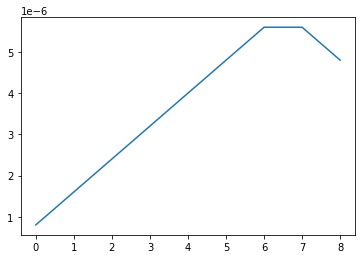

In [20]:
import matplotlib.pyplot as plt
plt.plot(list(range(len(lrs))), lrs)

## Inference with best model

In [15]:
#code to train best model
torch.save(trainer.model.state_dict(), "../working/alberto_repr_oneg/alberto_repr_oneg.pt")

In [ ]:
#load best model's params
model = MyNet(2)
model.load_state_dict(torch.load("../working/alberto_repr_oneg/alberto_repr_oneg.pt"))

In [ ]:
preds = model(testing)